<a href="https://colab.research.google.com/github/ankit3466/Deep-Learning/blob/master/Machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

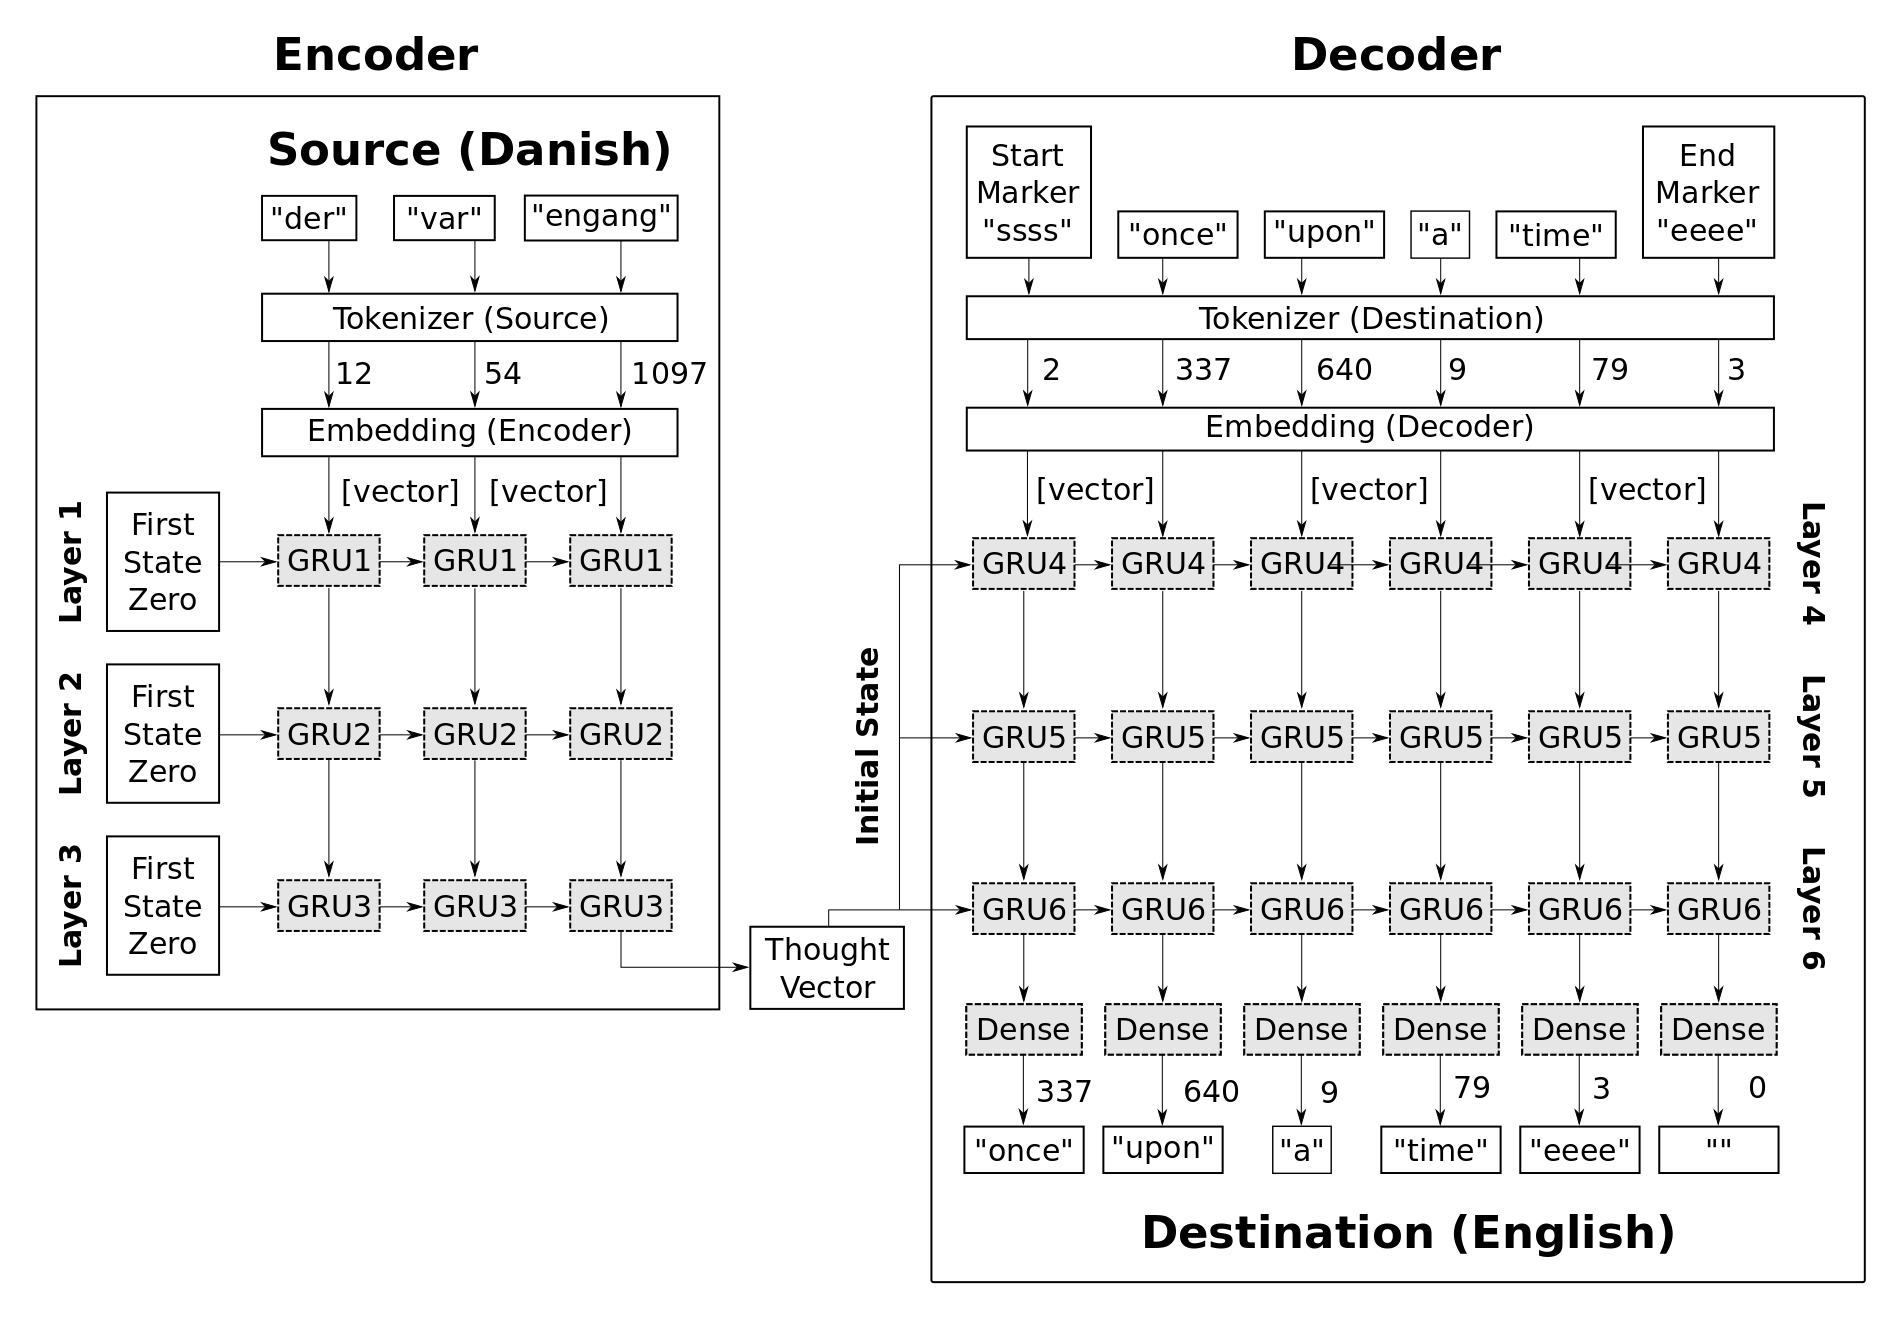

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

Using TensorFlow backend.


In [0]:
import numpy as np

In [0]:
with open('small_vocab_en.txt') as f:
  data = f.read()

english_sentences = data.split('\n')

with open('small_vocab_fr.txt') as f:
  data = f.read()

french_sentences = data.split('\n')

In [4]:
for sample_i in range(5):
    print('English sample {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('French sample {}:  {}\n'.format(sample_i + 1, french_sentences[sample_i]))

English sample 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
French sample 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

English sample 2:  the united states is usually chilly during july , and it is usually freezing in november .
French sample 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .

English sample 3:  california is usually quiet during march , and it is usually hot in june .
French sample 3:  california est généralement calme en mars , et il est généralement chaud en juin .

English sample 4:  the united states is sometimes mild during june , and it is cold in september .
French sample 4:  les états-unis est parfois légère en juin , et il fait froid en septembre .

English sample 5:  your least liked fruit is the grape , but my least liked is the apple .
French sample 5:  votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .



In [5]:
len(english_sentences)

137861

In [6]:
len(french_sentences)

137861

In [8]:
import collections

english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [9]:
english_words_counter

Counter({',': 140897,
         '.': 129039,
         '?': 811,
         'a': 1944,
         'am': 24,
         'and': 59850,
         'animal': 2304,
         'animals': 768,
         'apple': 4652,
         'apple.': 196,
         'apples': 5452,
         'apples.': 392,
         'april': 8954,
         'are': 870,
         "aren't": 36,
         'august': 8789,
         'automobile': 1944,
         'autumn': 9004,
         'banana': 4652,
         'banana.': 196,
         'bananas': 5452,
         'bananas.': 392,
         'bear': 192,
         'bears': 64,
         'beautiful': 8915,
         'been': 36,
         'between': 540,
         'big': 1016,
         'bird': 192,
         'birds': 64,
         'black': 972,
         'blue': 972,
         'busy': 8791,
         'but': 63987,
         'california': 11250,
         'car': 1944,
         'cat': 192,
         'cats': 64,
         'chilly': 8770,
         'china': 10953,
         'chinese': 312,
         'cold': 8878,
         'd

# Preprocess

In [0]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)

    return tokenizer.texts_to_sequences(x), tokenizer

def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    return pad_sequences(x, maxlen=length, padding='post')

def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x , 30)
    preprocess_y = pad(preprocess_y , 30)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [12]:
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 30
Max French sentence length: 30
English vocabulary size: 199
French vocabulary size: 344


In [0]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


#Model 1: Embedding (IMPLEMENTATION)

In [15]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(256, return_sequences=True))    
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

#tests.test_embed_model(embed_model)

# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

embed_rnn_model.summary()

embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 256)           51200     
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 256)           393984    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1024)          263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 1024)          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 345)           353625    
Total params: 1,061,977
Trainable params: 1,061,977
Non-trainable params: 0
_______________________________________________________

In [16]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
new jersey est parfois calme en l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']


#Model 2: Bidirectional RNNs (IMPLEMENTATION)

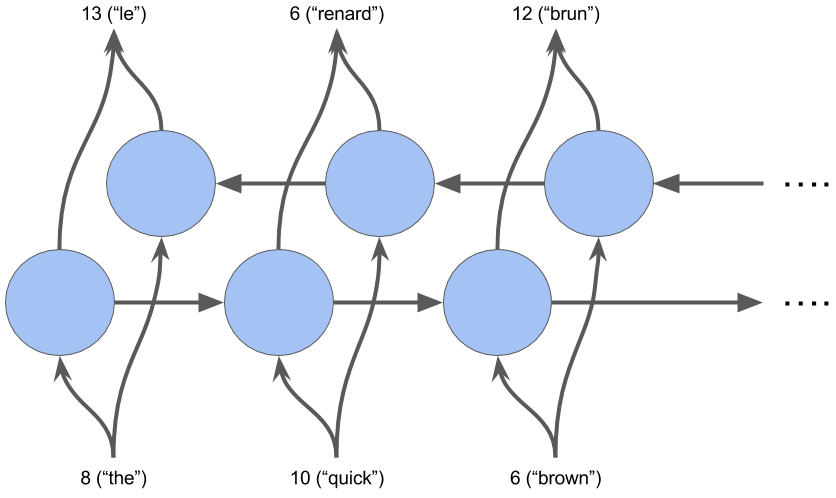

In [17]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.003
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences=True), input_shape=input_shape[1:]))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# TODO: Train and Print prediction(s)
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

embed_rnn_model.summary()

embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 256)           51200     
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 256)           393984    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1024)          263168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 1024)          0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 345)           353625    
Total params: 1,061,977
Trainable params: 1,061,977
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] -

In [18]:

# Print prediction(s)
print("Prediction:")
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

print("\nCorrect Translation:")
print(french_sentences[:1])

print("\nOriginal text:")
print(english_sentences[:1])

Prediction:
new jersey est parfois calme en l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
["new jersey est parfois calme pendant l' automne , et il est neigeux en avril ."]

Original text:
['new jersey is sometimes quiet during autumn , and it is snowy in april .']
